In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:90%;}
div.CodeMirror {font-family:Consolas; font-size:18pt;}
div.output {font-size:19pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd # read_csv,get_dumies(원핫인코딩)
from sklearn.model_selection import train_test_split #훈련셋과 시험셋 나누기
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.callbacks import EarlyStopping,Callback
from tensorflow.keras import metrics

import matplotlib.pyplot as plt
from pandas import get_dummies

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

- Red Wine 품질 등급 예측

```
1. 데이터 셋 확보 & 전처리
    독립변수, 종속변수 분리 -> 독립 변수 스케일 조정(StandardScaler), 종속변수 원핫 인코딩, 훈련셋과 테스트셋 분리
2. 모델구성(입력11,출력6)
3. 모델 학습 과정 설정(다중분류에 맞는 설정)
4. 학습시키기(callbacks이용)
5. 모델 평가 - 그래프,평가(테스트셋), 교차표
6. 모델 저장 및 모델사용하기
    
```

In [38]:
redwine = pd.read_csv('./data/winequality-red.csv',sep=';')
redwine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [39]:
redwine.quality.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [40]:
# 원핫인코딩을 하기 위해서 시리즈로 분리 
Input= redwine.iloc[:,:-1]
target= redwine.iloc[:,-1]
display(Input)
display(target)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

In [41]:
# scale 조정(StandardScaler)
scaler = StandardScaler()
scaled_input = pd.DataFrame(scaler.fit_transform(Input))
scaled_input.shape

(1599, 11)

In [42]:
# 종속변수 원핫 인코딩(get_dummies)
target = get_dummies(target).to_numpy()

In [43]:
target.shape

(1599, 6)

In [72]:
# scaled_input와 target => 학습셋: 테스트셋 = 0.75:0.25
X_train,X_test,y_train,y_test = train_test_split(scaled_input,
                                                target,
                                                test_size=0.25,
                                                random_state=1,
                                                stratify=target)# 층화추출(등급별 75:25로 추출)
X_train.shape,X_test.shape,y_train.shape,y_test.shape 

((1199, 11), (400, 11), (1199, 6), (400, 6))

In [76]:
np.c_[pd.Series(y_train.argmax(axis=1)+3).value_counts(),pd.Series(y_test.argmax(axis=1)+3).value_counts()
]

array([[511, 170],
       [478, 160],
       [149,  50],
       [ 40,  13],
       [ 13,   5],
       [  8,   2]], dtype=int64)

In [82]:
# 모델 생성 & 모델 구성
model= Sequential()
model.add(Dense(units=64, input_dim=11,activation = 'relu'))
model.add(Dense(units=128, activation = 'relu'))

model.add(Dense(units=64, activation = 'relu'))
model.add(Dense(units=6, activation = 'softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                768       
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 6)                 390       
                                                                 
Total params: 17,734
Trainable params: 17,734
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [84]:
import tensorflow.keras.callbacks as callbacks
class CustomHistory(callbacks.Callback): # on_epoch_end()
    def __init__(self): # 생성자함수
        self.epoch=0
    def on_epoch_end(self, batch,logs={}):
        self.epoch += 1
        if self.epoch%5 ==5:
            print('epoch:{},loss:{},acc:{},val_loss:{},val_acc:{}'.\
                 format(self.epoch,logs.get('loss'),logs.get('accuracy'),logs.get('val_loss'),logs.get('val_accuracy')))
# 모델 학습
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(patience=20) # val_accuracy가 연달아 2번이상 성능이 좋아지지않으면 stop(loss,accuracy,val_loss,val_accuracy)
customHistory = CustomHistory()
hist = model.fit(X_train, y_train , epochs=1000,batch_size=100,
                validation_split=0.2,
                callbacks=[earlyStopping,customHistory])

Epoch 1/1000
10/10 [==============================] - 1s 20ms/step - loss: 0.6202 - accuracy: 0.4088 - val_loss: 0.5259 - val_accuracy: 0.4083
Epoch 2/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.4672 - accuracy: 0.4327 - val_loss: 0.3968 - val_accuracy: 0.4083
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.3673 - accuracy: 0.4692 - val_loss: 0.3302 - val_accuracy: 0.5167
Epoch 4/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.3258 - accuracy: 0.5610 - val_loss: 0.3034 - val_accuracy: 0.5542
Epoch 5/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.3083 - accuracy: 0.5641 - val_loss: 0.2926 - val_accuracy: 0.5542
Epoch 6/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.2979 - accuracy: 0.5860 - val_loss: 0.2893 - val_accuracy: 0.5708
Epoch 7/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.2914 - accuracy: 0.5933 - val_loss: 0.2900 - val_accuracy: 0.5667
Epoch

In [85]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

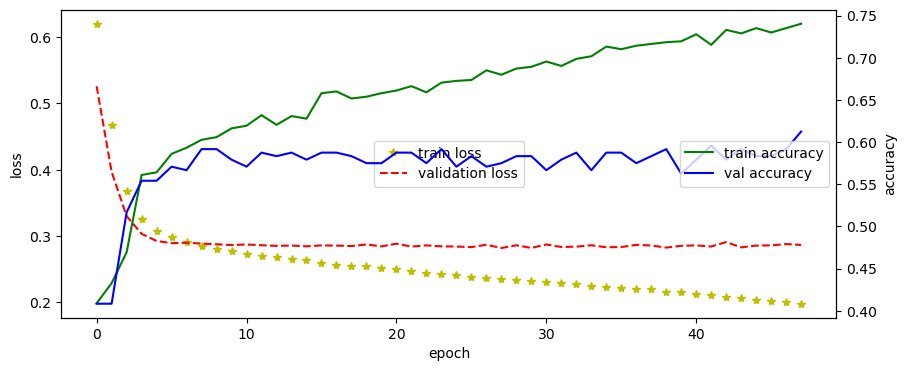

In [86]:
# 학습과정 중의 loss와 accuracy
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,4))
loss_ax.plot(hist.history['loss'],'y*',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r--',label='validation loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'],'g',label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'],'b',label='val accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [88]:
Y_hat = model.predict(X_test).argmax(axis=1)+3
ctab = pd.crosstab(y_test.argmax(axis=1)+3,Y_hat)

ctab

13/13 [==============================] - 0s 1ms/step


col_0,4,5,6,7
row_0,,,,
3,0,2,0,0
4,0,8,5,0
5,1,128,39,2
6,0,55,99,6
7,0,4,32,14
8,0,0,3,2


In [89]:
model.save('model/winequality.h5')

In [61]:
redwine.sample()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
450,11.9,0.39,0.69,2.8,0.095,17.0,35.0,0.9994,3.1,0.61,10.8,6
